In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import jax
from pathlib import Path


In [308]:
experiment_folder = 'mis/dmala_lowhigh_800'
directory = Path(f'{experiment_folder}')

In [309]:
results = {}
for folder in directory.iterdir():
    if folder.is_dir():
        experiment_name = str(folder)[len(experiment_folder)+1:]
        if experiment_name[0] != '.':
            with open(f'{experiment_folder}/{experiment_name}/results.pkl', 'rb') as file:
                results[experiment_name] = pickle.load(file)

In [310]:
result_dfs = []

for exp in results:
    df = pd.DataFrame({'mean_objective': np.mean(results[exp]['trajectory'],axis=1),
                       'std_objective': np.std(results[exp]['trajectory'],axis=1),
                       'experiment': exp,
                       'running time': results[exp]['running_time']})
    result_dfs.append(df)

df = pd.concat(result_dfs)

In [311]:
mean_df = df.pivot(values='mean_objective',columns='experiment')
std_df = df.pivot(values='std_objective',columns='experiment')

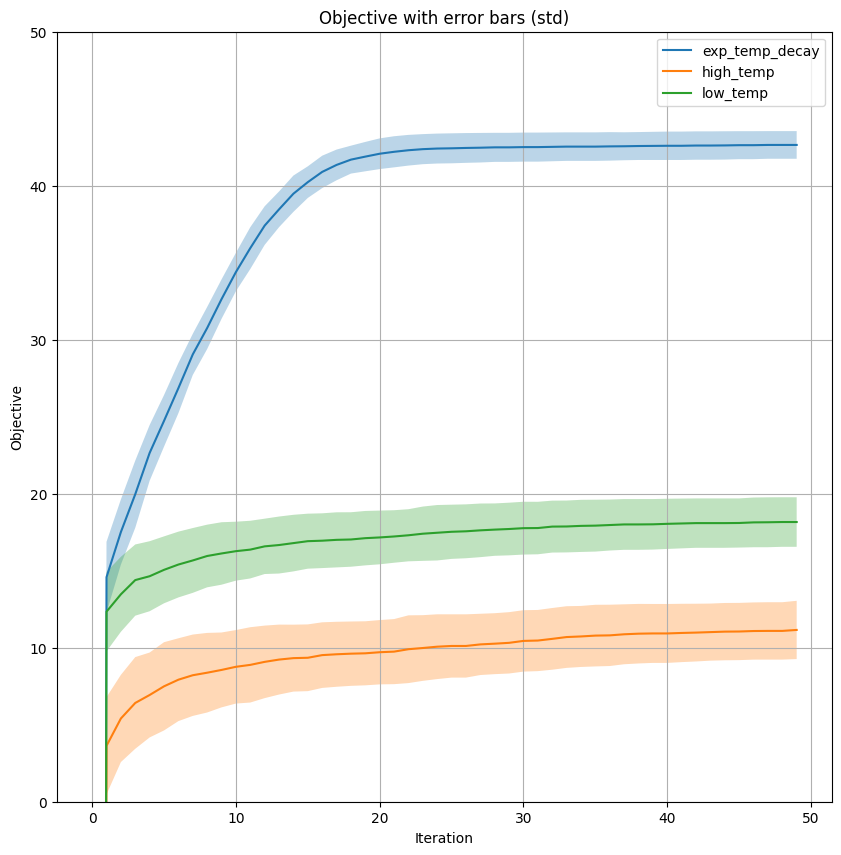

In [314]:
fig, ax = plt.subplots(figsize=(10,10))

# Loop through each column and plot the mean with the shaded area
for column in mean_df.columns:
    ax.plot(mean_df.index, mean_df[column], label=column)
    ax.fill_between(mean_df.index, 
                    mean_df[column] - std_df[column], 
                    mean_df[column] + std_df[column], 
                    alpha=0.3)  # alpha for transparency

# Adding labels, title, and legend
ax.set_xlabel('Iteration')  # Change this as appropriate
ax.set_ylabel('Objective')
ax.set_title('Objective with error bars (std)')
ax.legend()
ax.set_ylim(0,50)
ax.grid()
plt.show()
fig.savefig(experiment_folder+'/plot.png')

In [283]:
experiment_name = 'high_temp'

In [284]:
with open(f'mis/{experiment_name}/results.pkl', 'rb') as file:
    # Load the object from the file
    results = pickle.load(file)

In [285]:
trajectory = results['trajectory']

In [286]:
df = pd.DataFrame(trajectory)

<Axes: >

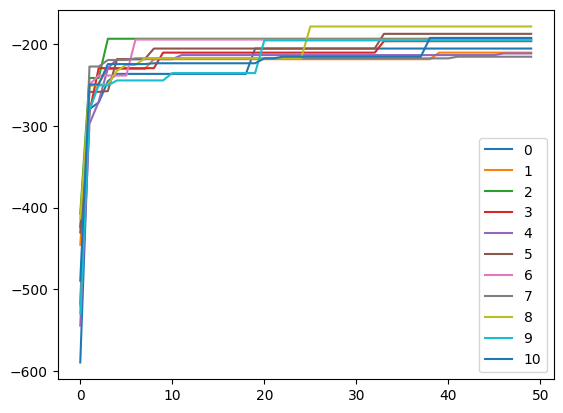

In [287]:
df.loc[:,0:10].plot()

In [212]:
results['trajectory'][-1,:]

array([   43.000004, -7706.0293  , -7154.468   ,    41.000004,
       -8459.797   ,    42.000004,    43.000004, -8446.784   ,
       -7128.441   , -8831.175   ,    42.000004, -8228.56    ,
       -9188.54    , -8380.714   , -7470.7847  ,    43.000004,
       -9629.985   , -8848.191   , -8084.412   , -9503.86    ,
          43.000004,    42.000004, -8552.89    , -9284.637   ,
       -7037.3447  , -8899.241   , -8798.138   , -7391.706   ,
       -6945.255   , -8039.37    , -9304.657   , -8312.648   ,
          42.000004, -7159.4707  ,    41.000004, -9837.199   ,
       -9323.676   , -8384.721   , -9232.581   , -7719.042   ,
          42.000004, -9149.495   ,    42.000004, -9276.629   ,
       -9636.991   , -7087.398   ,    43.000004, -7072.379   ,
       -7522.841   , -9141.488   , -8110.44    ,    42.000004,
       -9303.656   , -9444.797   ,    42.000004, -9237.589   ,
       -8047.3726  ,    42.000004, -8238.57    ,    43.000004,
          42.000004, -8675.017   , -8147.477   , -8218.

In [213]:
results['best_ratio']

array([   43.000004, -7706.0293  , -7154.468   ,    41.000004,
       -8459.797   ,    42.000004,    43.000004, -8446.784   ,
       -7128.441   , -8831.175   ,    42.000004, -8228.56    ,
       -9188.54    , -8380.714   , -7470.7847  ,    43.000004,
       -9629.985   , -8848.191   , -8084.412   , -9503.86    ,
          43.000004,    42.000004, -8552.89    , -9284.637   ,
       -7037.3447  , -8899.241   , -8798.138   , -7391.706   ,
       -6945.255   , -8039.37    , -9304.657   , -8312.648   ,
          42.000004, -7159.4707  ,    41.000004, -9837.199   ,
       -9323.676   , -8384.721   , -9232.581   , -7719.042   ,
          42.000004, -9149.495   ,    42.000004, -9276.629   ,
       -9636.991   , -7087.398   ,    43.000004, -7072.379   ,
       -7522.841   , -9141.488   , -8110.44    ,    42.000004,
       -9303.656   , -9444.797   ,    42.000004, -9237.589   ,
       -8047.3726  ,    42.000004, -8238.57    ,    43.000004,
          42.000004, -8675.017   , -8147.477   , -8218.

In [88]:
experiment_name = 'bernoulli_hightemp'

with open(f'{experiment_name}/samples.pkl', 'rb') as file:
    # Load the object from the file
    samples = pickle.load(file)['trajectory']

with open(f'{experiment_name}/params.pkl', 'rb') as file:
    # Load the object from the file
    params = pickle.load(file)['params']

In [89]:
samples.shape

(10000, 4, 10)

In [90]:
1/(1+np.exp(params))

array([0.48286   , 0.5026763 , 0.54163533, 0.39785805, 0.3373209 ,
       0.5768507 , 0.487088  , 0.41803205, 0.39282462, 0.6176615 ],
      dtype=float32)

In [91]:
samples = np.array(samples)

In [92]:
samples[1000:,2,0].mean()

0.12566666666666668

In [69]:
samples[:,1,0].mean()

Array(0.2819, dtype=float32)

In [94]:
rng = jax.random.PRNGKey(0)

In [97]:
keys = jax.random.split(rng,5)

In [100]:
jax.vmap(jax.random.normal)(keys)

Array([-0.9204866 , -0.738873  ,  1.6133053 , -1.5701252 , -0.55517924],      dtype=float32)

In [ ]:
import importlib
from absl import app
from absl import flags
from discs.common import configs as common_configs
from discs.common import utils
import discs.common.experiment_saver as saver_mod
from ml_collections import config_flags

In [146]:
# CONFIG
model_name = 'mis'
experiment_name = 'exponential'
sampler_name = 'randomwalk'
graph_type = 'ertest'

experiment_config = importlib.import_module(
        f'discs.experiment.configs.{model_name}.{graph_type}'
    )
experiment_config = experiment_config.get_config()

model_config = importlib.import_module(
        f'discs.models.configs.{model_name}_config'
    )

model_config = model_config.get_config()

sampler_config = importlib.import_module(
        f'discs.samplers.configs.{sampler_name}_config'
    )

sampler_config = sampler_config.get_config()

In [147]:
def get_main_config():
  """Merge experiment, model and sampler config."""
  config = common_configs.get_config()
  if (
      'graph_type' not in model_config
      and 'bert_model' not in model_config
  ):
    config.update(experiment_config)
  config.sampler.update(sampler_config)
  config.model.update(model_config)
  if config.model.get('graph_type', None):
    graph_config = importlib.import_module(
        'discs.models.configs.%s.%s'
        % (config.model['name'], config.model['graph_type'])
    )
    config.model.update(graph_config.get_model_config(config.model['cfg_str']))
    co_exp_default_config = importlib.import_module(
        'discs.experiment.configs.co_experiment'
    )
    config.experiment.update(co_exp_default_config.get_co_default_config())
    config.update(experiment_config)
    config.experiment.num_models = config.model.num_models

  if config.model.get('bert_model', None):
    config.update(experiment_config)

  return config

In [150]:
config = get_main_config()

In [153]:
config.get('samplser',0)

0

In [158]:
config.update({'experiment':{'test':'jup'}})

In [159]:
config

experiment:
  batch_size: 32
  chain_length: 50000
  co_opt_prob: true
  decay_rate: 0.01
  ess_ratio: 0.5
  evaluator: co_eval
  fig_folder: ''
  final_temperature: 0.0001
  get_additional_metrics: false
  get_estimation_error: false
  init_temperature: 1
  log_every_steps: 100
  name: CO_Experiment
  num_models: 128
  plot_every_steps: 10
  run_parallel: true
  save_every_steps: 100
  save_root: ''
  save_samples: false
  shuffle_buffer_size: 0
  t_schedule: exp_decay
  test: jup
  use_tqdm: false
  window_size: 10
  window_stride: 10
experiment_name: test
model:
  cfg_str: r-800
  data_root: ./sco/
  graph_type: ertest
  max_num_edges: 47885
  max_num_nodes: 800
  name: mis
  num_categories: 2
  num_instances: 128
  num_models: 128
  penalty: 1.001
  rand_type: '800'
  save_dir_name: mis
  shape: !!python/tuple
  - 0
sampler:
  adaptive: true
  name: randomwalk
  target_acceptance_rate: 0.237

In [160]:
experiments = [{'experiment_name': 'exp_temp_decay',
                'experiment': {'t_schedule': 'exp_decay'}},
                {'experiment_name': 'high_temp',
                'experiment': {'t_schedule': 'constant',
                               'init_temperature': 1}},
                {'experiment_name': 'high_temp',
                'experiment': {'t_schedule': 'constant',
                               'init_temperature': 0.01}}]

In [167]:
experiment ={'experiment_name': 'high_temp',
                'experiment': {'t_schedule': 'constant',
                               'init_temperature': 1}}

In [168]:
config.update(experiment)

In [164]:
config

experiment:
  batch_size: 32
  chain_length: 50000
  co_opt_prob: true
  decay_rate: 0.01
  ess_ratio: 0.5
  evaluator: co_eval
  fig_folder: ''
  final_temperature: 0.0001
  get_additional_metrics: false
  get_estimation_error: false
  init_temperature: 1
  log_every_steps: 100
  name: CO_Experiment
  num_models: 128
  plot_every_steps: 10
  run_parallel: true
  save_every_steps: 100
  save_root: ''
  save_samples: false
  shuffle_buffer_size: 0
  t_schedule: exp_decay
  test: jup
  use_tqdm: false
  window_size: 10
  window_stride: 10
experiment_name: exp_temp_decay
model:
  cfg_str: r-800
  data_root: ./sco/
  graph_type: ertest
  max_num_edges: 47885
  max_num_nodes: 800
  name: mis
  num_categories: 2
  num_instances: 128
  num_models: 128
  penalty: 1.001
  rand_type: '800'
  save_dir_name: mis
  shape: !!python/tuple
  - 0
sampler:
  adaptive: true
  name: randomwalk
  target_acceptance_rate: 0.237